In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics as mt
from tabulate import tabulate
from sklearn.svm import LinearSVC
import sklearn.model_selection as ms
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
from time import sleep
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
filename = 'data_sentiment.csv'
names = ['product.name', 'brand.name', 'review.text', 'review.process', 'review.tokened', 'score', 'sentiment']
fields = ['review.tokened', 'sentiment']
review = pd.read_csv(filename, names=names, usecols=fields)
review.head()

,review.tokened,sentiment
0,feel lucky find use phone not use hard phone l...,positive
1,nice phone nice grade pantach revue clean set ...,positive
2,pleased,positive
3,work good go slow sometimes good phone love,positive
4,great phone replace lose phone thing volume bu...,positive


In [5]:

# split data 70% train 30% test
print('split data --- start')
array = review.values
X = array[:, 0:1]

Y = array[:, 1]
review['sentiment']

size = 0.3


split data --- start


In [6]:
# testX and trainX is review.tokened
# testY and trainY is sentiment
trainX, testX, trainY, testY = ms.train_test_split(X, Y, test_size=size, shuffle=True)
print('split data --- end')
print(trainY)

split data --- end
['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']


In [7]:
# feature extraction
print('feature extraction --- start')
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1, 2), sublinear_tf=False,
                     max_features=10000, smooth_idf=True, stop_words='english')
tv_train = tv.fit_transform(trainX.ravel())

tv_test = tv.transform(testX.ravel())  # transform test review into features
print('feature extraction --- end')

print()

feature extraction --- start
feature extraction --- end



In [8]:
# latent semantic analysis on train data (lexicon based)
print('latent semantic analysis --- start')
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_train = lsa.fit_transform(tv_train)
#print(lsa_train)
lsa_test = lsa.transform(tv_test)  # transform tfidf test
print('latent semantic analysis --- end')

latent semantic analysis --- start
latent semantic analysis --- end


In [9]:
# build model and predict with lsa train (machine learning)
print('build and predict --- start')
svm = LinearSVC()
svm.fit(lsa_train, trainY)
svm_pred = svm.predict(lsa_test)
print('build and predict --- end')

print()


build and predict --- start
build and predict --- end



In [13]:
# evaluation
print('\nModel Evaluation:')
svm_accuracy = np.round(mt.accuracy_score(testY, svm_pred), 3)
svm_precision = np.round(mt.precision_score(testY, svm_pred, average='macro'), 3)
svm_recall = np.round(mt.recall_score(testY, svm_pred, average='macro'), 3)
svm_f1 = np.round(mt.f1_score(testY, svm_pred, average='macro'), 3)

svm_metrics = np.array([svm_accuracy, svm_precision, svm_recall, svm_f1])
svm_metrics = pd.DataFrame([svm_metrics], columns=['accuracy', 'precision', 'recall', 'f1'], index=['metrics'])
print('Performance Metrics:')
print(tabulate(svm_metrics, headers='keys'))


Model Evaluation:
Performance Metrics:
           accuracy    precision    recall     f1
-------  ----------  -----------  --------  -----
metrics        0.81        0.712     0.684  0.697


<Figure size 432x288 with 0 Axes>

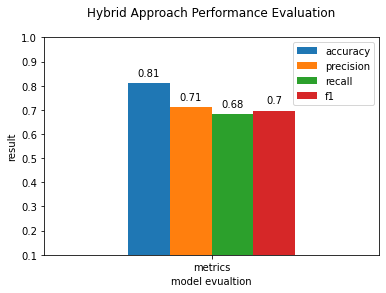

In [11]:
fig = plt.figure()
ax = svm_metrics.plot.bar()
plt.title('Hybrid Approach Performance Evaluation\n')
plt.ylabel('result')
plt.xlabel('model evualtion')
plt.xticks(rotation=-360)  # rotate x labels
plt.ylim([0.1, 1.0])
for item in ax.patches:  # show value on plot
    ax.annotate(np.round(item.get_height(), decimals=2), (item.get_x() + item.get_width() / 2., item.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.savefig('../results/hybrid_performance.png', format='png', transparent=False)  # save result
plt.show()


Confusion Matrix of Hybrid Approach:



<ipython-input-14-5df26325bc1e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-14-5df26325bc1e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


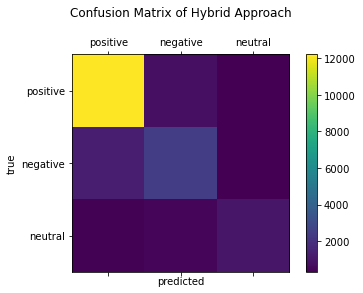

In [14]:
print('\nConfusion Matrix of Hybrid Approach:\n')

# display and plot confusion matrix
labels = ['positive', 'negative', 'neutral']
svm_cm = mt.confusion_matrix(testY, svm_pred, labels=labels)

# plot
# display and plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Confusion Matrix of Hybrid Approach\n')
fig.colorbar(ax.matshow(svm_cm))
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('predicted')
plt.ylabel('true')
plt.savefig('../results/hybrid_confusion_matrix.png',  format='png', transparent=False)  # save result
plt.show()

In [15]:
print('\nClassification Report of Hybrid Approach to Sentiment Analysis:\n')

# classification report for hybrid approach
svm_report = mt.classification_report(testY, svm_pred, labels=labels)
print(svm_report)

print()


Classification Report of Hybrid Approach to Sentiment Analysis:

              precision    recall  f1-score   support

    positive       0.88      0.91      0.89     13385
    negative       0.65      0.60      0.63      4129
     neutral       0.60      0.54      0.57      1911

    accuracy                           0.81     19425
   macro avg       0.71      0.68      0.70     19425
weighted avg       0.80      0.81      0.81     19425




In [16]:
# output performance to csv
svm_metrics.to_csv('hybrid_performance_result.csv', index=None, header=True)

# end of hybrid approach